In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Number of samples. 
n = 1000
# Generate "time" variable. 
t = np.arange(n)

data_df = pd.DataFrame({'t' : t})

Seasonal Component \
Let us define a function to generate seasonal components (Fourier modes).

In [4]:
# Generate seasonal variables. 
def seasonal(t, amplitude, period):
    """Generate a sinusoidal curve."""
    y1 = amplitude * np.sin((2*np.pi)*t/period) 
    return y1

# Add two seasonal components. 
data_df['s1'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=2, period=40))

# Define target variable. 
data_df['y1'] = data_df['s1']

Let us plot this seasonal variable:

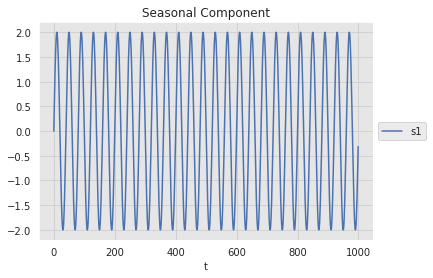

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='s1', data=data_df, color=sns_c[0], label='s1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Seasonal Component', xlabel='t', ylabel='');

Gaussian Noise \
Finally, we add some noise.

In [6]:
# Set noise standard deviation. 
sigma_n = 0.3

data_df['epsilon'] = np.random.normal(loc=0, scale=sigma_n, size=n)
# Add noise to target variable. 
data_df ['y1'] = data_df ['y1'] + data_df ['epsilon']

Let us plot the resulting data:

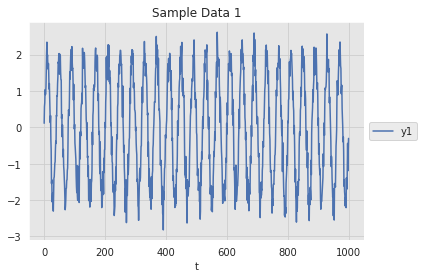

In [8]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 1', xlabel='t', ylabel='');

Define Model

Let us now define the kernel of the gaussian process model. We include the following kernel components (recall that the sum of kernels is again a kernel):

WhiteKernel to account for noise.

ExpSineSquared to model the periodic component.

We add bounds to the kernel hyper-parameters which are optimized by maximizing the log-marginal-likelihood (see documentation).

White kernel.

The main use-case of this kernel is as part of a sum-kernel where it explains the noise of the signal as independently and identically normally-distributed. The parameter noise_level equals the variance of this noise.

$k\left(x_{1}, x_{2}\right)=$ noise_level if $x_{i}==x_{j}$ else 0

Exp-Sine-Squared kernel (aka periodic kernel).

The ExpSineSquared kernel allows one to model functions which repeat themselves exactly. It is parameterized by a length scale parameter L and a periodicity parameter P . Only the isotropic variant where  is a scalar is supported at the moment. The kernel is given by:

$k\left(x_{i}, x_{j}\right)=\exp \left(-\frac{2 \sin ^{2}\left(\pi d\left(x_{i}, x_{j}\right) / p\right)}{l^{2}}\right)$ \\
where l is the length scale of the kernel, p the periodicity of the kernel and d is the Euclidean distance


In [10]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

kernel_1  = k0 + k1 


Next we initialize the GaussianProcessRegressor object.

n_restarts_optimizer:The number of restarts of the optimizer for finding the kernel’s parameters which maximize the log-marginal likelihood. 

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp1 = GaussianProcessRegressor(
    kernel=kernel_1, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

Split Data

We now prepare and split the data for the model.


In [14]:

X = data_df['t'].values.reshape(n, 1)
y = data_df['y1'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

Prior Sampling

Let us sample from the prior distribution and compare it with our given data.

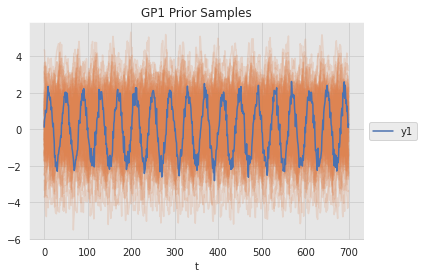

In [24]:
gp1_prior_samples = gp1.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp1_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');

Model Fit + Predictions

Let us fit the model and generate predictions.

In [26]:
gp1.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0,
                kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=40),
                n_restarts_optimizer=10, normalize_y=True)
# Generate predictions.
y_pred, y_std = gp1.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

We plot the predictions.

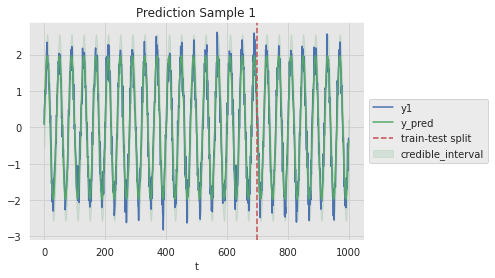

In [27]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y1', data=data_df, color=sns_c[0], label = 'y1', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 1', xlabel='t', ylabel='');

Let us compute the R2(coefficient of determination, which can be negative) and the Mean Absolute Error of the prediction on the train and test set.

In [28]:
from sklearn.metrics import mean_absolute_error
print(f'R2 Score Train = {gp1.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp1.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp1.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp1.predict(X_test)): 0.3f}')

R2 Score Train =  0.956
R2 Score Test =  0.960
MAE Train =  0.241
MAE Test =  0.229


Errors

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


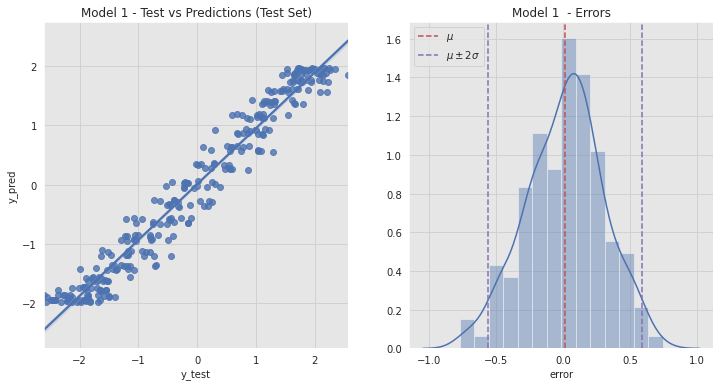

In [37]:
errors = gp1.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp1.predict(X_test).flatten(), ax=ax[0])

sns.distplot(a=errors, ax=ax[1])

ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')

ax[1].legend()
ax[0].set(title='Model 1 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 1  - Errors', xlabel='error', ylabel=None);

Example 2

In this example we add a linear trend component.

In [38]:
# Generate trend component. 
def linear_trend(beta, x):
    """Scale vector by a scalar."""
    trend_comp = beta * x 
    return trend_comp

data_df['tr1'] = data_df['t'].apply(lambda x : linear_trend(0.01, x))

# Add trend to target variable y_1. 
data_df['y2'] = data_df['y1'] + data_df['tr1']

Let us see the trend plot:

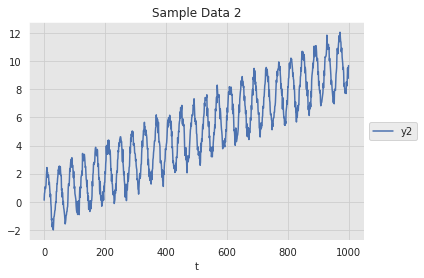

In [40]:
fig, ax = plt.subplots()
sns.lineplot(x='t', y='y2', data=data_df, color=sns_c[0], label='y2', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 2', xlabel='t', ylabel='');

Define Model

For this second example we add a RBF kernel to model the trend componen

In [42]:
from sklearn.gaussian_process.kernels import RBF

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=12) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * \
  RBF(length_scale=1e2, length_scale_bounds=(1, 1e3)) 

kernel_2  = k0 + k1 + k2
# Define GaussianProcessRegressor object. 
gp2 = GaussianProcessRegressor(
    kernel=kernel_2, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

Split Data
We split the data as above.

In [43]:
y = data_df['y2'].values.reshape(n, 1)
y_train = y[:n_train]
y_test = y[n_train:]

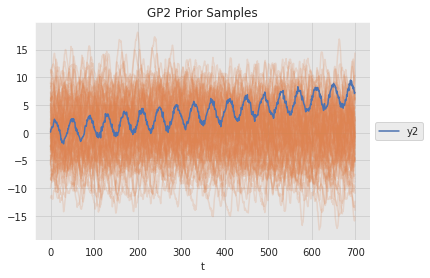

In [44]:
#Prior Sampling
gp2_prior_samples = gp2.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp2_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y2', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP2 Prior Samples', xlabel='t');

Model Fit + Predictions

In [46]:
gp2.fit(X_train, y_train)

# Generate predictions.
y_pred, y_std = gp2.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

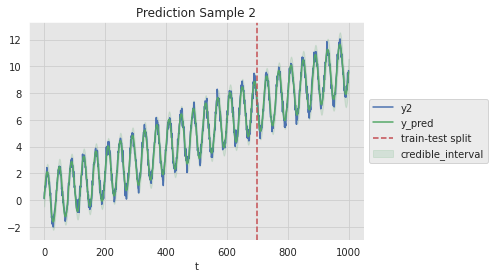

In [47]:
fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y2', data=data_df, color=sns_c[0], label = 'y2', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample 2', xlabel='t', ylabel='');

In [48]:
print(f'R2 Score Train = {gp2.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp2.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp2.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp2.predict(X_test)): 0.3f}')

R2 Score Train =  0.985
R2 Score Test =  0.971
MAE Train =  0.240
MAE Test =  0.232


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


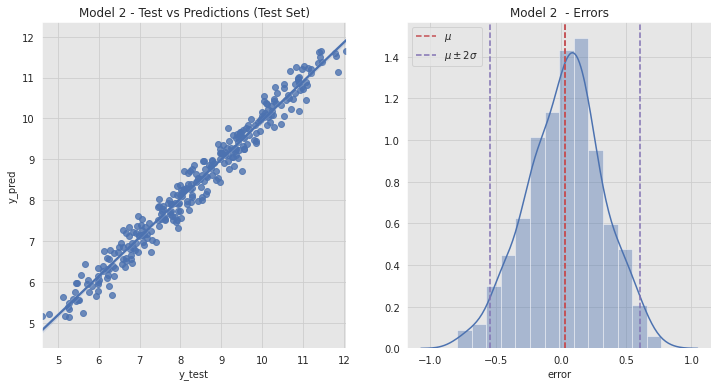

In [49]:
errors = gp2.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp2.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 2 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 2  - Errors', xlabel='error', ylabel=None);

Example 3

In this third example we add a second seasonal component.



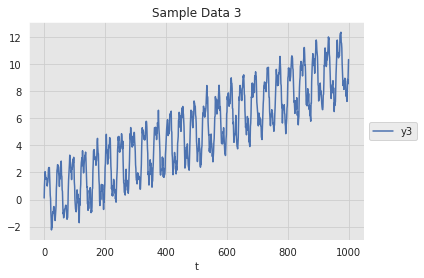

In [52]:
# Create other seasonal component.
data_df['s2'] = data_df['t'].apply(lambda t : seasonal(t, amplitude=1, period=13.3))
# Add to y_2.
data_df['y3'] = data_df['y2'] + data_df['s2'] 

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y3', data=data_df, color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 3', xlabel='t', ylabel='');

In [55]:
#Define Model
#We add another ExpSineSquared kernel to the one of Example 2.

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=25, constant_value_bounds=(1e-2, 1e3)) * \
  RBF(length_scale=100.0, length_scale_bounds=(1, 1e4)) 

k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_3  = k0 + k1 + k2 + k3

# Define GaussianProcessRegressor object. 
gp3 = GaussianProcessRegressor(
    kernel=kernel_3, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [56]:
y = data_df['y3'].values.reshape(n, 1)
y_train = y[:n_train]
y_test = y[n_train:]

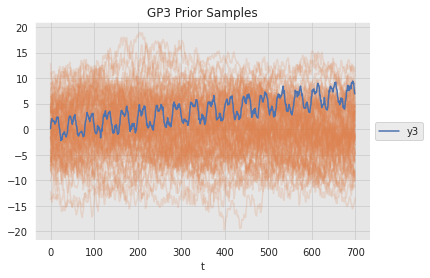

In [57]:
#Prior Sampling
gp3_prior_samples = gp3.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp3_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP3 Prior Samples', xlabel='t');

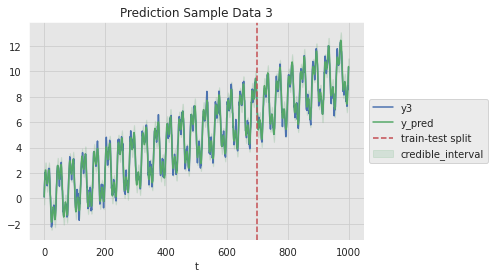

In [58]:
gp3.fit(X_train, y_train)
y_pred, y_std = gp3.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y3', data=data_df, color=sns_c[0], label = 'y3', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 3', xlabel='t', ylabel='');

In [59]:
print(f'R2 Score Train = {gp3.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp3.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp3.predict(X_test)): 0.3f}')

R2 Score Train =  0.987
R2 Score Test =  0.974
MAE Train =  0.239
MAE Test =  0.240


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


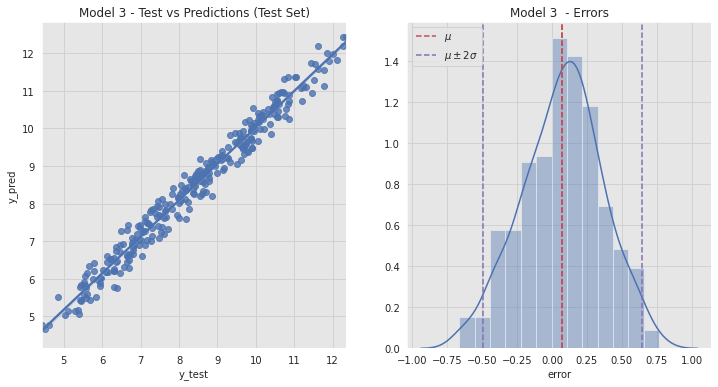

In [60]:
errors = gp3.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp3.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 3 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 3  - Errors', xlabel='error', ylabel=None);

Example 4

In this last example we consider a non-linear trend component.

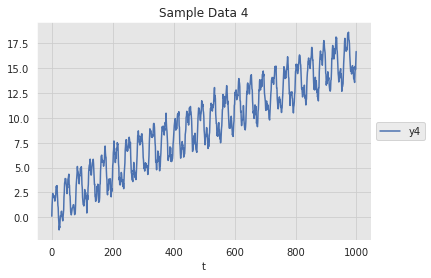

In [66]:
# Generate trend component. 
def non_linear_trend(x):
    """Scale and take square root."""
    trend_comp = 0.2 * np.power(x, 1/2)
    return trend_comp

# Compute non-linear trend. 
data_df ['tr2'] = data_df['t'].apply(non_linear_trend)

# Add trend to target variable. 
data_df ['y4'] = data_df ['y3'] + data_df ['tr2']

fig, ax = plt.subplots()
sns.lineplot(x='t', y='y4', data=data_df, color=sns_c[0], label='y4', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Sample Data 4', xlabel='t', ylabel='');

Instead of an RBF kernel to model the trendd, we use a RationalQuadratic which can seen as a scale mixture (an infinite sum) of RBF kernels with different characteristic length-scales.

$k\left(x_{i}, x_{j}\right)=\left(1+\frac{d\left(x_{i}, x_{j}\right)^{2}}{2 \alpha l^{2}}\right)^{-\alpha}$

In [68]:
from sklearn.gaussian_process.kernels import RationalQuadratic

k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(35, 45))

k2 = ConstantKernel(constant_value=100, constant_value_bounds=(1, 500)) * \
  RationalQuadratic(length_scale=500, length_scale_bounds=(1, 1e4), alpha= 50.0, alpha_bounds=(1, 1e3))

k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3

gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

Split Data


In [69]:
y = data_df['y4'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

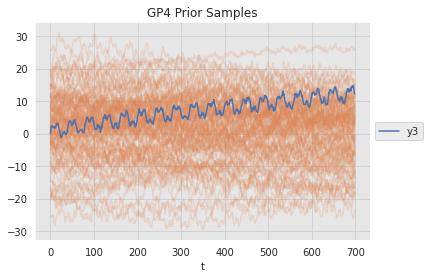

In [70]:
#Prior Sampling
gp4_prior_samples = gp4.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y3', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP4 Prior Samples', xlabel='t');

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


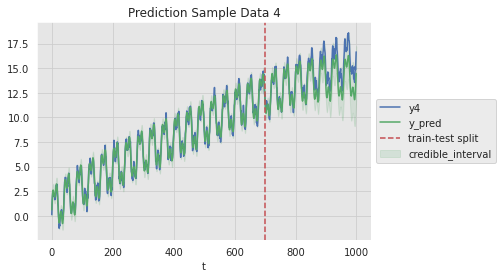

In [72]:
#Model Fit + Predictions
gp4.fit(X_train, y_train)

y_pred, y_std = gp4.predict(X, return_std=True)

data_df['y_pred'] = y_pred
data_df['y_std'] = y_std
data_df['y_pred_lwr'] = data_df['y_pred'] - 2*data_df['y_std']
data_df['y_pred_upr'] = data_df['y_pred'] + 2*data_df['y_std']

fig, ax = plt.subplots()

ax.fill_between(
    x=data_df['t'], 
    y1=data_df['y_pred_lwr'], 
    y2=data_df['y_pred_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='y4', data=data_df, color=sns_c[0], label = 'y4', ax=ax)
sns.lineplot(x='t', y='y_pred', data=data_df, color=sns_c[2], label='y_pred', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');

In [73]:
print(f'R2 Score Train = {gp4.score(X=X_train, y=y_train): 0.3f}')
print(f'R2 Score Test = {gp4.score(X=X_test, y=y_test): 0.3f}')
print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp4.predict(X_train)): 0.3f}')
print(f'MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp4.predict(X_test)): 0.3f}')

R2 Score Train =  0.992
R2 Score Test =  0.699
MAE Train =  0.254
MAE Test =  0.847


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


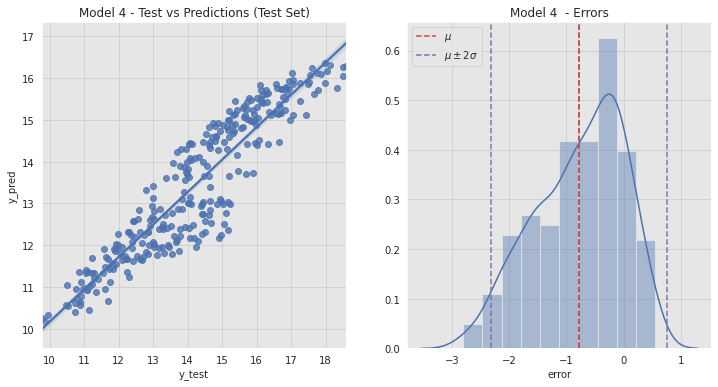

In [74]:
errors = gp4.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp4.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 4 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Model 4  - Errors', xlabel='error', ylabel=None);

The aim of this notebook was to give a flavor on how to use Gaussian processes for time series forecasting. I strongly encourage you to go to the references presented above to get a deeper understanding of this subject.